# Desafío Final - Grupo 2
---
#### Analisis discursivo audiovisual
**Integrantes:**<br/>
Franco Pelecchia <br/>
Nestor Magariños<br/>
Diego Lesertesseur<br/>
Horacio E. Suarez

<a id="section_toc"></a> 

---

## Tabla de Contenidos

[1- Preprocesamiento de Datos](#section_1)

&emsp; [1.1- Seteo de valor de fragmento temporal](#section_1_1)

&emsp; [1.2- Recorte temporal para los datos extraidos de audio](#section_1_2)

&emsp; [1.3- Ensamble y recorte temporal para los datos extraidos de video](#section_1_3)



In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import os
import spacy
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import unidecode
import re
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS 


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\envs\dhds\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<a id="section_1"></a> 
###  1- Preprocesamiento de datos
[volver a TOC](#section_toc)

----
<b><a id='section_1_2'>1.2- Recorte temporal para los datos extraidos de audio</a></b>

In [2]:
audio_path = "../Data Procesada/data_audio.csv"
audio = pd.read_csv(audio_path)
print(audio.shape)
audio.head(3)

(1923, 8)


,Unnamed: 0,folder,path_audio,file,date,text,start,end
0,0,C5N,../Data/Audio/C5N/C5N2020-08-15-17-00-45.wav,C5N2020-08-15-17-00-45.wav,2020-08-15 17:00:45,grande bueno aun con el inefable en estos días...,2020-08-15 17:00:45,2020-08-15 17:01:27
1,1,C5N,../Data/Audio/C5N/C5N2020-08-15-17-00-45.wav,C5N2020-08-15-17-00-45.wav,2020-08-15 17:00:45,hola hola cómo le va bienvenido buenas tardes ...,2020-08-15 17:01:59,2020-08-15 17:02:14
2,2,C5N,../Data/Audio/C5N/C5N2020-08-15-17-00-45.wav,C5N2020-08-15-17-00-45.wav,2020-08-15 17:00:45,visto y abrazo grande desde acá de todo el equ...,2020-08-15 17:02:15,2020-08-15 17:03:00


In [3]:
#Seteo del intervalo delta
delta = 21
td = datetime.timedelta(minutes=delta)

In [4]:
# Convertimos las columnas necesarias para operar con tiempos
audio['start'] = audio['start'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
audio['end'] = audio['end'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

audio.dtypes

Unnamed: 0             int64
folder                object
path_audio            object
file                  object
date                  object
text                  object
start         datetime64[ns]
end           datetime64[ns]
dtype: object

In [5]:
# Join de textos en el intervalo Delta
registrosAudio =  pd.DataFrame(columns=['folder', 'file','deltaStart', 'deltaEnd','textDelta'])

for file in audio['file'].unique():
    
    maskFile =  audio['file'] == file
    
    folder = audio.loc[maskFile, 'folder'].unique()
    
    deltaStart = audio.loc[maskFile, 'start'].min()
    deltaEnd = deltaStart + td
    
    endFile = audio.loc[maskFile, 'end'].max()
    n_delta=1
    while deltaStart <= endFile:
        
        maskDelta = (audio['start'] >= deltaStart) & (audio['end'] < deltaEnd)
        
        audio.loc[maskDelta & maskFile,'deltaStart'] = deltaStart
        
        audio.loc[maskDelta & maskFile,'deltaEnd'] = deltaEnd

        text = audio.loc[maskDelta & maskFile,'text'].unique()
        textDelta = ','.join(text)
        newInput=pd.DataFrame([textDelta], columns=['textDelta'])
        newInput['words_counts'] = [len(x.split()) for x in newInput['textDelta'].tolist()]
        newInput['file'] = file
        newInput['folder'] = folder
        newInput['deltaStart'] = deltaStart
        newInput['deltaEnd'] = deltaEnd
        newInput['deltaStep'] = n_delta
        newInput.reset_index(inplace=True)
        
        registrosAudio = registrosAudio.append(newInput)
        n_delta=n_delta+1
        deltaStart = deltaStart + td
        deltaEnd = deltaStart + td
        
#registrosAudio.drop(['index'],axis=1)
registrosAudio['file'] = registrosAudio['file'].apply(lambda x: x.split('.')[0]) 
registrosAudio.rename(columns={"folder": "fuente"}, inplace=True)
print(registrosAudio.shape)
registrosAudio['deltaStep'] = registrosAudio['deltaStep'].apply(lambda x: int(x))
registrosAudio.reset_index(drop=True,inplace=True)
registrosAudio.head(10)

(75, 8)


,fuente,file,deltaStart,deltaEnd,textDelta,index,words_counts,deltaStep
0,C5N,C5N2020-08-15-17-00-45,2020-08-15 17:00:45,2020-08-15 17:21:45,grande bueno aun con el inefable en estos días...,0.0,2791.0,1
1,C5N,C5N2020-08-15-17-00-45,2020-08-15 17:21:45,2020-08-15 17:42:45,por eso esto que pasa en barcelona era impensa...,0.0,3169.0,2
2,C5N,C5N2020-08-15-17-00-45,2020-08-15 17:42:45,2020-08-15 18:03:45,las nueve de la mañana diez para tres de la ma...,0.0,2467.0,3
3,C5N,C5N2020-08-15-17-00-45,2020-08-15 18:03:45,2020-08-15 18:24:45,más en el caso del fútbol a diferencia de otro...,0.0,1648.0,4
4,C5N,C5N2020-08-15-17-00-45,2020-08-15 18:24:45,2020-08-15 18:45:45,bueno ahora trabaja más pero siempre está pres...,0.0,2385.0,5
5,C5N,C5N2020-08-15-17-00-45,2020-08-15 18:45:45,2020-08-15 19:06:45,alguna según este estudio que se hizo tienen q...,0.0,2695.0,6
6,C5N,C5N2020-08-15-17-00-45,2020-08-15 19:06:45,2020-08-15 19:27:45,y ese ministerio tiene una dirección en salud ...,0.0,2332.0,7
7,C5N,C5N2020-08-15-17-00-45,2020-08-15 19:27:45,2020-08-15 19:48:45,la puso a trujillo ahora miguel el aire decidí...,0.0,3088.0,8
8,C5N,C5N2020-08-15-17-00-45,2020-08-15 19:48:45,2020-08-15 20:09:45,líbano y así de esta manera poder ayudar esta ...,0.0,2644.0,9
9,C5N,C5N2020-08-15-17-00-45,2020-08-15 20:09:45,2020-08-15 20:30:45,es casi haría como como hacia el papa distinto...,0.0,1899.0,10


----
<b><a id='section_1_3'>1.3- Ensamble y recorte temporal para los datos extraidos de video</a></b>

In [6]:
videoTablePath = "../Data procesada/TablasVideo/"
data_video = pd.DataFrame()

for videoTable in os.listdir(videoTablePath):
    registro = pd.read_csv(videoTablePath + videoTable)
    #print(registro.shape)
    data_video = pd.concat([data_video, registro])

data_video.drop(['Unnamed: 0'], axis=1, inplace=True)
data_video['file'] = data_video['file'].apply(lambda x: x if x is np.NaN else x.split('.')[0])
video = data_video
video['datetime'] = video['fecha_hora'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
video.drop(columns=['fecha_hora'],inplace=True)
video.head()

,personaje,genero,file,fuente,datetime
0,SIN PERSONAS IDENTIFICABLES,NaN,C5N2020-08-14-17-55-49,C5N,2020-08-14 17:55:49
1,SIN PERSONAS IDENTIFICABLES,NaN,C5N2020-08-14-17-55-49,C5N,2020-08-14 17:55:50
2,SIN PERSONAS IDENTIFICABLES,NaN,C5N2020-08-14-17-55-49,C5N,2020-08-14 17:55:51
3,SIN PERSONAS IDENTIFICABLES,NaN,C5N2020-08-14-17-55-49,C5N,2020-08-14 17:55:52
4,SIN PERSONAS IDENTIFICABLES,NaN,C5N2020-08-14-17-55-49,C5N,2020-08-14 17:55:53


In [7]:
registrosVideo =  pd.DataFrame()

for file in video['file'].unique():
    
    maskFile =  video['file'] == file
    
    deltaStart = video.loc[maskFile, 'datetime'].min()
    deltaEnd = deltaStart + td
    
    endFile = video.loc[maskFile, 'datetime'].max()
    n_delta=1    
    while deltaStart <= endFile:
        
        
        maskDelta = (video['datetime'] >= deltaStart) & (video['datetime'] < deltaEnd)
        
        video.loc[maskDelta & maskFile,'deltaStart'] = deltaStart
        
        video.loc[maskDelta & maskFile,'deltaEnd'] = deltaEnd
        
        newInput = video.loc[maskDelta & maskFile, ['deltaStart', 'deltaEnd', 'file','fuente','personaje','genero']]
        newInput = newInput.groupby(['deltaStart', 'deltaEnd', 'file','fuente','genero'])['personaje'].value_counts()

        
        
        newInput = pd.DataFrame(newInput)
        newInput.rename(columns={'personaje':'segundos'},inplace=True)
        newInput['deltaStep'] = n_delta
        newInput.reset_index(inplace=True)
        
        registrosVideo = registrosVideo.append(newInput)
        n_delta=n_delta+1
        deltaStart = deltaStart + td
        deltaEnd = deltaStart + td
        
registrosVideo

,deltaStart,deltaEnd,file,fuente,genero,personaje,segundos,deltaStep
0,2020-08-14 17:55:49,2020-08-14 18:16:49,C5N2020-08-14-17-55-49,C5N,F,c_pablo_duggan,652,1
1,2020-08-14 17:55:49,2020-08-14 18:16:49,C5N2020-08-14-17-55-49,C5N,F,c_julian_guarino,271,1
2,2020-08-14 17:55:49,2020-08-14 18:16:49,C5N2020-08-14-17-55-49,C5N,F,NO IDENTIFICADO,57,1
3,2020-08-14 17:55:49,2020-08-14 18:16:49,C5N2020-08-14-17-55-49,C5N,F,patricia_bullrich,4,1
4,2020-08-14 17:55:49,2020-08-14 18:16:49,C5N2020-08-14-17-55-49,C5N,F,liilta_carrio,3,1
...,...,...,...,...,...,...,...,...
23,2020-08-25 20:44:36,2020-08-25 21:05:36,TN2020-08-25-18-59-36,TN,M,eduardo_duhalde,1,6
24,2020-08-25 20:44:36,2020-08-25 21:05:36,TN2020-08-25-18-59-36,TN,M,gerard_pique,1,6
25,2020-08-25 20:44:36,2020-08-25 21:05:36,TN2020-08-25-18-59-36,TN,M,horacio_rodriguez_larreta_2,1,6
26,2020-08-25 20:44:36,2020-08-25 21:05:36,TN2020-08-25-18-59-36,TN,M,nelson_castro,1,6


---
### Identificación de personas en el video

In [45]:
mask_NoConductores = registrosVideo['personaje'].apply(lambda x: 'c_' not in x)
mask_NoIdentificados = registrosVideo['personaje'] !=  'NO IDENTIFICADO'
mask_SinPersonas = registrosVideo['personaje'] !=  'SIN PERSONAS IDENTIFICABLES'
mask_final = mask_NoConductores & mask_NoIdentificados & mask_SinPersonas

In [46]:
registrosVideo_PersonasFile = registrosVideo.loc[mask_final, ['file','personaje','genero','segundos']]
registrosVideo_PersonasFile = pd.DataFrame(registrosVideo_PersonasFile.groupby(['file','genero','personaje'])['segundos'].sum()).reset_index()
registrosVideo_PersonasFile = registrosVideo_PersonasFile.sort_values(by=['file','genero','segundos'],ascending=False)
registrosVideo_PersonasFile.head()

,file,genero,personaje,segundos
344,TN2020-08-25-18-59-36,M,sergio_berensztein,326
340,TN2020-08-25-18-59-36,M,matias_posada,170
335,TN2020-08-25-18-59-36,M,jorge_lanata,120
334,TN2020-08-25-18-59-36,M,hugo_sigman,36
329,TN2020-08-25-18-59-36,M,eduardo_duhalde,24


In [47]:
registrosVideo_PersonasDelta = registrosVideo.loc[mask_final, ['file','deltaStep','personaje','genero','segundos']]
registrosVideo_PersonasDelta = pd.DataFrame(registrosVideo_PersonasDelta.groupby(['file','deltaStep','genero','personaje'])['segundos'].sum()).reset_index()
registrosVideo_PersonasDelta = registrosVideo_PersonasDelta.sort_values(by=['file','deltaStep','genero','segundos'],ascending=False)
registrosVideo_PersonasDelta.head()

,file,deltaStep,genero,personaje,segundos
1015,TN2020-08-25-18-59-36,6,M,matias_posada,165
1012,TN2020-08-25-18-59-36,6,M,hernan_lombardi,6
1014,TN2020-08-25-18-59-36,6,M,luis_naidenoff,2
1009,TN2020-08-25-18-59-36,6,M,daniel_gollan,1
1010,TN2020-08-25-18-59-36,6,M,eduardo_duhalde,1


---
### Identificación de género en video

In [10]:
registrosVideo_GeneroFile = registrosVideo.loc[:, ['file','genero','segundos']]
registrosVideo_GeneroFile = pd.DataFrame(registrosVideo_GeneroFile.groupby(['file','genero'])['segundos'].sum()).reset_index()
registrosVideo_GeneroFile = registrosVideo_GeneroFile.sort_values(by=['file','segundos'],ascending=False)
registrosVideo_GeneroFile.head()

,file,genero,segundos
19,TN2020-08-25-18-59-36,M,5157
18,TN2020-08-25-18-59-36,F,1126
17,TN2020-08-18-19-00-19,M,5188
16,TN2020-08-18-19-00-19,F,2513
15,TN2020-08-17-19-00-08,M,6892


In [11]:
mask_Conductores = registrosVideo['personaje'].apply(lambda x: 'c_' in x)

registrosVideo_GeneroConductoresFile = registrosVideo.loc[mask_final, ['file','genero','segundos']]
registrosVideo_GeneroConductoresFile = pd.DataFrame(registrosVideo_GeneroConductoresFile.groupby(['file','genero'])['segundos'].sum()).reset_index()
registrosVideo_GeneroConductoresFile = registrosVideo_GeneroConductoresFile.sort_values(by=['file','segundos'],ascending=False)
registrosVideo_GeneroConductoresFile.head()

,file,genero,segundos
19,TN2020-08-25-18-59-36,M,775
18,TN2020-08-25-18-59-36,F,203
17,TN2020-08-18-19-00-19,M,1562
16,TN2020-08-18-19-00-19,F,839
15,TN2020-08-17-19-00-08,M,3013


In [50]:
registrosVideo_GeneroDelta = registrosVideo.loc[:, ['file','genero','deltaStep','segundos']]
registrosVideo_GeneroDelta = pd.DataFrame(registrosVideo_GeneroDelta.groupby(['file','genero','deltaStep',])['segundos'].sum()).reset_index()
registrosVideo_GeneroDelta = registrosVideo_GeneroDelta.sort_values(by=['file','deltaStep','segundos'],ascending=False)
registrosVideo_GeneroDelta.head()

,file,genero,deltaStep,segundos
150,TN2020-08-25-18-59-36,M,6,659
144,TN2020-08-25-18-59-36,F,6,151
149,TN2020-08-25-18-59-36,M,5,969
143,TN2020-08-25-18-59-36,F,5,183
148,TN2020-08-25-18-59-36,M,4,1077


In [51]:
mask_Conductores = registrosVideo['personaje'].apply(lambda x: 'c_' in x)

registrosVideo_GeneroConductoresDelta = registrosVideo.loc[mask_final, ['file','genero','deltaStep','segundos']]
registrosVideo_GeneroConductoresDelta = pd.DataFrame(registrosVideo_GeneroConductoresDelta.groupby(['file','genero','deltaStep',])['segundos'].sum()).reset_index()
registrosVideo_GeneroConductoresDelta = registrosVideo_GeneroConductoresDelta.sort_values(by=['file','deltaStep','segundos'],ascending=False)
registrosVideo_GeneroConductoresDelta.head()

,file,genero,deltaStep,segundos
146,TN2020-08-25-18-59-36,M,6,179
140,TN2020-08-25-18-59-36,F,6,38
145,TN2020-08-25-18-59-36,M,5,232
139,TN2020-08-25-18-59-36,F,5,9
144,TN2020-08-25-18-59-36,M,4,170


---
### Name entity recognition

In [52]:
def LabelsLG(text):
    lgLoad = spacy.load("es_core_news_lg")
    entities = []
    labels = []
    df = pd.DataFrame([], columns=["Entities", 'Labels'])
    trainedText = lgLoad(text)
    
    for ent in trainedText.ents:
        entities.append(ent)
        labels.append(ent.label_)
        df = pd.concat([df,pd.DataFrame({'Entities':entities,'Labels':labels})])        
    df["textEntities"] = df.Entities.apply(lambda x : x.text)
    return df


def GetPersonsCount (text):
    df = LabelsLG(text)
    return df.textEntities[df.Labels=="PER"].value_counts()


def AddPerson (dataFrame,seriePerson):   
    for person in seriePerson.index:
        if not person in dataFrame.columns:
            dataFrame[person] = 0
            
    return dataFrame


def AddEmptyRow (dataFrame):   
    newRow = pd.DataFrame([[0] * dataFrame.shape[1]], columns=dataFrame.columns)
    dataFrame = pd.concat([dataFrame, newRow], ignore_index=True)
    
    return dataFrame
  
    
def AddContent (dataFrame, text, file, deltaStep):

    personCount =  GetPersonsCount (text)

    dataFrame = AddPerson (dataFrame,personCount)

    dataFrame = AddEmptyRow(dataFrame)

    dataFrame.loc[dataFrame.index[-1],"text"] = text
    dataFrame.loc[dataFrame.index[-1],"file"] = file
    dataFrame.loc[dataFrame.index[-1],"deltaStep"] = deltaStep
    
    for person in personCount.index:
        dataFrame.iloc[-1, dataFrame.columns.get_loc(person)] = personCount[person]
    return dataFrame

def DataFrameGenerator (DataFrame, textChannelSeries):       
    for row in textChannelSeries.index:
        DataFrame = AddContent(DataFrame,textChannelSeries.textDelta[row], textChannelSeries.file[row],textChannelSeries.deltaStep[row])
    
    return DataFrame

def SortDataFrame (dataFrame):
    sums = dataFrame.sum()
    return dataFrame[sums.sort_values(ascending=False).index] 

In [53]:
dataFrameEmpty = pd.DataFrame([], columns = ["file","text",'deltaStep'])
texts = registrosAudio[['file','textDelta','deltaStep']]
dataFrameFinal = DataFrameGenerator(dataFrameEmpty, texts)
dataFrameFinal.head()

,file,text,deltaStep,sáenz,alberto fernández,matías,néstor de ir,hola hola,messi,pablito,...,néstor kirchner carlos kirchner,roberto barata,roberto saviano libros,roxana carvajal,roxana caravana,roxana,maría del carmen saavedra,zamora,carvajal roxana,facundo estudio
0,C5N2020-08-15-17-00-45,grande bueno aun con el inefable en estos días más tarde tempranito soy un poco más tarde si no ...,1,207,169,158,71,70,70,69,...,0,0,0,0,0,0,0,0,0,0
1,C5N2020-08-15-17-00-45,por eso esto que pasa en barcelona era impensado ahora era impensado que barcelona quedar elimin...,2,0,0,0,0,0,932,0,...,0,0,0,0,0,0,0,0,0,0
2,C5N2020-08-15-17-00-45,las nueve de la mañana diez para tres de la mañana y se arranca arrancamos a un producto fresco ...,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C5N2020-08-15-17-00-45,más en el caso del fútbol a diferencia de otros deportes siempre está esta cosa de la hazaña de ...,4,0,0,0,0,0,101,0,...,0,0,0,0,0,0,0,0,0,0
4,C5N2020-08-15-17-00-45,bueno ahora trabaja más pero siempre está presente y bueno mi hermano central en que tenían la p...,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,TN2020-08-18-19-00-19,la organización internacional europea investigación criminal pero si tenemos la red nacional de ...,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71,TN2020-08-18-19-00-19,pregunta es políticamente la práctica quién puede capitalizar lo al margen dura declaración o de...,3,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72,TN2020-08-18-19-00-19,actualmente no sea la gente que tiene que salir a la calle porque tal vez lo que está faltando e...,4,0,39,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
73,TN2020-08-18-19-00-19,curar todo pero bueno de esto se volvió actor totalmente agresivo y tuve que ponerle un punto fi...,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
NER = pd.melt(dataFrameFinal, value_vars=dataFrameFinal.drop(columns=["file","text",'deltaStep']).columns.values, id_vars=["file",'deltaStep'] )
NER.rename(columns={'value':'ocurrencias','variable':'personaje'},inplace=True)
NERDelta=NER.loc[NER['ocurrencias']>0,:]
NERDelta = NERDelta.sort_values(by=['file','deltaStep','ocurrencias'],ascending=False)
NERDelta

,file,deltaStep,personaje,ocurrencias
56837,TN2020-08-25-18-59-36,6,franco,136
62912,TN2020-08-25-18-59-36,6,martín gonzález,128
57587,TN2020-08-25-18-59-36,6,tina,83
62987,TN2020-08-25-18-59-36,6,dime,82
17537,TN2020-08-25-18-59-36,6,tomás,81
...,...,...,...,...
39557,C5N2020-08-14-17-55-49,1,edward,7
39632,C5N2020-08-14-17-55-49,1,eduardo lópez,6
39707,C5N2020-08-14-17-55-49,1,miguel ángel,3
14957,C5N2020-08-14-17-55-49,1,patricia bull,2


In [76]:
NERFile = pd.DataFrame(NERDelta.groupby(["file",'personaje'])['ocurrencias'].sum()).reset_index()
NERFile = NERFile.sort_values(by=['file','ocurrencias'],ascending=False)
NERFile

,file,personaje,ocurrencias
1201,TN2020-08-25-18-59-36,duhalde,764
1253,TN2020-08-25-18-59-36,macri,711
1172,TN2020-08-25-18-59-36,alberto fernández,672
1261,TN2020-08-25-18-59-36,mauricio macri,414
1221,TN2020-08-25-18-59-36,franco,377
...,...,...,...
45,C5N2020-08-14-17-55-49,julian buenas tardes bueno,2
69,C5N2020-08-14-17-55-49,patricia bull,2
11,C5N2020-08-14-17-55-49,cornejo,1
49,C5N2020-08-14-17-55-49,leandro gabriele,1


----------
### Stopwords

In [17]:
stopwords_sp_1 = pd.DataFrame(stopwords.words('spanish'),columns=["stopwords"])
stopwords_sp_2 = pd.read_csv("../Varios/stopwords.txt",header=None,names=["stopwords"]) #https://countwordsfree.com/stopwords/spanish/txt
print("stopwords_sp_1:",stopwords_sp_1.shape[0])
print("stopwords_sp_2:",stopwords_sp_2.shape[0])

stopwords_sp_1: 313
stopwords_sp_2: 443


In [18]:
stopwords_sp_3 = stopwords_sp_2.append(stopwords_sp_1)

In [19]:
stopwords_sp = []
for word in stopwords_sp_3.values:
    word_clean =  unidecode.unidecode(str(word[0]).lower())
    if word_clean not in stopwords_sp:
        stopwords_sp.append(word_clean)

In [20]:
print("Conjunto final de stopwords:",len(stopwords_sp))

Conjunto final de stopwords: 591


----------
### Stemming

Aplicamos stemming a las stopwords

In [21]:
def stemfraseesp_for_stopwords(frase):    
    token_words=word_tokenize(frase)
    stem_sentence=[]    
    spanishStemmer=SnowballStemmer("spanish")
    for word in token_words:
        stem_sentence.append(spanishStemmer.stem(word))
    return "".join(stem_sentence)

In [22]:
stopwords_sp_stemming = []
for word in stopwords_sp:
    stopword_stem = stemfraseesp_for_stopwords(word)
    if stopword_stem not in stopwords_sp_stemming:
        stopwords_sp_stemming.append(stopword_stem)

Creamos una tabla que nos permita conservar cuál es la palabra origina de cada stemming para que luego de contar las palabras podamos transformarla en su forma original

In [23]:
texto_completo = "".join(registrosAudio['textDelta'])
texto_completo=unidecode.unidecode(texto_completo.lower()); # sacamos acentos y llevamos a minuscula
texto_completo=re.sub(r'([^\s\w]|_)+','',texto_completo); # quitamos signos de puntuacion usando una regex que reemplaza todo lo q no sean espacios o palabras por un string vacio

In [24]:
token_words=word_tokenize(texto_completo)
stem_sentence=[]    
token_words_clean=[]
spanishStemmer=SnowballStemmer("spanish")
for word in token_words:
    if len(word)>2:
        word_stem = spanishStemmer.stem(word)
        if word_stem not in stopwords_sp_stemming:
            stem_sentence.append(word_stem)
            token_words_clean.append(word)

In [25]:
stem_match = pd.DataFrame([token_words_clean,stem_sentence],index=['original','stem']).T
stem_match =  pd.DataFrame(stem_match.groupby('stem')['original'].value_counts())
stem_match.columns = ['count']
stem_match.reset_index(inplace=True)

In [26]:
stem_match = stem_match.sort_values(by='count', ascending=False)
stem_match.drop_duplicates(subset=['stem'],keep='first', inplace=True)
stem_match.reset_index(drop=True,inplace=True)
print("Tabla para matcheo")
print(stem_match.shape)
stem_match.head()

Tabla para matcheo
(8828, 3)


,stem,original,count
0,gent,gente,516
1,gobiern,gobierno,386
2,dia,dia,345
3,argentin,argentina,341
4,mil,mil,244


--------
### Stemming por delta y file


In [78]:
def stemfraseesp(frase):    
    token_words=word_tokenize(frase)
    stem_sentence=[]    
    token_words_clean=[]
    spanishStemmer=SnowballStemmer("spanish")
    for word in token_words:
        if len(word)>2:
            word_stem = spanishStemmer.stem(word)
            if word_stem not in stopwords_sp_stemming:
                stem_sentence.append(word_stem)
                stem_sentence.append(" ")
    return "".join(stem_sentence)

In [105]:
textos = registrosAudio.loc[:,'textDelta']

textos_limpios=[];
for t in textos:
    t_lower_no_accents=unidecode.unidecode(t.lower()); # sacamos acentos y llevamos a minuscula
    t_lower_no_accents_no_punkt=re.sub(r'([^\s\w]|_)+','',t_lower_no_accents); # quitamos signos de puntuacion usando una regex que reemplaza todo lo q no sean espacios o palabras por un string vacio
    textos_limpios.append(t_lower_no_accents_no_punkt)
    
textos_finalDelta = []
for t in textos_limpios:
    textos_finalDelta.append(stemfraseesp(t))

In [104]:
auxiliar = registrosAudio.loc[:,['file','textDelta']]

textos=[]
for file in auxiliar['file'].unique():
    mask=auxiliar['file']==file
    newInput= ' '.join(auxiliar.loc[mask,'textDelta'])
    textos.append(newInput)
    
textos_limpios=[];
for t in textos:
    t_lower_no_accents=unidecode.unidecode(t.lower()); # sacamos acentos y llevamos a minuscula
    t_lower_no_accents_no_punkt=re.sub(r'([^\s\w]|_)+','',t_lower_no_accents); # quitamos signos de puntuacion usando una regex que reemplaza todo lo q no sean espacios o palabras por un string vacio
    textos_limpios.append(t_lower_no_accents_no_punkt)
    
textos_finalFile = []
for t in textos_limpios:
    textos_finalFile.append(stemfraseesp(t))

------------------------
### CountVectorizer

In [120]:
vectorizerDelta=CountVectorizer(stop_words=stopwords_sp,lowercase=True,ngram_range=(1,1), max_df=0.7); #revisar si tenemos que poner stopwords acá, creo que no
vectorizerDelta.fit(textos_finalDelta);

In [121]:
if len(vectorizerDelta.get_feature_names()[0].split(' '))==2:
    aux = pd.Series(vectorizerDelta.get_feature_names())
    aux = aux.str.split(' ',expand=True)
    aux.columns= ['word1','word2']
    aux = aux.merge(stem_match,how='left', left_on='word1',right_on='stem')
    aux = aux.merge(stem_match,how='left', left_on='word2',right_on='stem',suffixes=('_1','_2'))
    features_namesDelta= aux['original_1']+" "+aux['original_2']
else:
    aux = pd.DataFrame(vectorizerDelta.get_feature_names())
    aux.columns=['word1']
    features_namesDelta= aux.merge(stem_match, how='left',left_on='word1',right_on='stem')['original']

In [126]:
CV_encodingDelta=vectorizerDelta.transform(textos_finalDelta);
pd.DataFrame(CV_encodingDelta.todense(),columns=features_namesDelta).sum().sort_values(ascending=False)[0:20]

original
marcha        247
cuarentena    237
politica      218
provincia     201
chicos        199
cambio        180
reforma       168
semana        153
policia       148
tarde         147
equipo        133
comprar       132
tipo          130
contagio      130
judicial      129
nino          129
muerte        127
necesita      126
mal           125
cuidado       123
dtype: int64

In [123]:
vectorizerFile=CountVectorizer(stop_words=stopwords_sp,lowercase=True,ngram_range=(1,1), max_df=0.7); #revisar si tenemos que poner stopwords acá, creo que no
vectorizerFile.fit(textos_finalFile);

In [124]:
if len(vectorizerFile.get_feature_names()[0].split(' '))==2:
    aux = pd.Series(vectorizerFile.get_feature_names())
    aux = aux.str.split(' ',expand=True)
    aux.columns= ['word1','word2']
    aux = aux.merge(stem_match,how='left', left_on='word1',right_on='stem')
    aux = aux.merge(stem_match,how='left', left_on='word2',right_on='stem',suffixes=('_1','_2'))
    features_namesFile= aux['original_1']+" "+aux['original_2']
else:
    aux = pd.DataFrame(vectorizerFile.get_feature_names())
    aux.columns=['word1']
    features_namesFile= aux.merge(stem_match, how='left',left_on='word1',right_on='stem')['original']

In [129]:
CV_encodingFile=vectorizerFile.transform(textos_finalFile);
pd.DataFrame(CV_encodingFile.todense(),columns=features_namesFile).sum().sort_values(ascending=False)[0:20]

original
nino          129
barcelona     113
cuerpo        101
duhalde        86
habilitado     70
deportes       68
cloro          64
dioxido        63
autopsia       58
suba           52
pablo          52
democracia     51
disfrutar      50
espana         50
militar        48
descuento      48
frontera       46
cumplir        46
futbol         45
discurso       43
dtype: int64

-----------------
### Term Frequency Inverse Document Frequency (TF-IDF)

In [ ]:
aux = pd.Series(registrosAudio['file'].apply(lambda x: x.replace(".wav","").split("-")[-6:]))
aux = aux.apply(lambda x: [int(a) if len(a)<=4 else int(a[-4:]) for a in x])
registrosAudio['date'] = aux.apply(lambda x: datetime.datetime(x[0], x[1], x[2], hour=x[3], minute=x[4], second=x[5]))
file = registrosAudio['fuente'] +" "+ registrosAudio['date'].apply(lambda x: str(x.month)+"-"+str(x.day))+" Step "+registrosAudio['deltaStep'].apply(lambda x: str(x))
file.reset_index(inplace=True,drop=True)

In [127]:
Tfidf_encodingDelta=TfidfTransformer().fit_transform(CV_encodingDelta);
pd.DataFrame(Tfidf_encodingDelta.todense(),columns=features_namesDelta,index=file).head()

original,aah,aaires,aasi,abadia,abajo,abalos,abandono,abandonadospero,abanicosoy,abarca,...,zgonzalez,zocalo,zombis,zona,zonaparece,zonapor,zoomaplica,zorro,zumo,zurich
C5N 8-15 Step 1,0.0,0.0,0.0,0.0,0.023955,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
C5N 8-15 Step 2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.010871,0.0,0.0,0.0,0.0,0.0,0.0
C5N 8-15 Step 3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.032723,...,0.0,0.0,0.0,0.050016,0.0,0.0,0.0,0.0,0.0,0.0
C5N 8-15 Step 4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
C5N 8-15 Step 5,0.0,0.0,0.0,0.0,0.024542,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.013946,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
Tfidf_encodingFile=TfidfTransformer().fit_transform(CV_encodingFile);
pd.DataFrame(Tfidf_encodingFile.todense(),columns=features_namesFile,index=auxiliar['file'].unique()).head()

original,aah,aaires,aasi,abadia,abajo,abalos,abandono,abandonadospero,abanicosoy,abarca,...,zelanda,zgonzalez,zocalo,zombis,zonaparece,zonapor,zoomaplica,zorro,zumo,zurich
C5N2020-08-15-17-00-45,0.0,0.010757,0.000000,0.000000,0.010487,0.0,0.008000,0.0,0.000000,0.009145,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0
C5N2020-08-17-17-54-34,0.0,0.000000,0.000000,0.016869,0.008223,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.016869,0.000000,0.016869,0.0,0.0,0.000000,0.00000,0.0
C5N2020-08-25-17-55-42,0.0,0.000000,0.000000,0.000000,0.006071,0.0,0.000000,0.0,0.012454,0.000000,...,0.021174,0.0,0.000000,0.012454,0.000000,0.0,0.0,0.000000,0.00000,0.0
C5N2020-08-18-17-57-53,0.0,0.000000,0.015117,0.000000,0.000000,0.0,0.011243,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.015117,0.01285,0.0
C5N2020-08-14-17-55-49,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0


-----------
### Tópicos

In [135]:
tfidf_Delta = pd.DataFrame(Tfidf_encodingDelta.todense(),columns=features_namesDelta)
tfidf_Delta.index = file
tfidf_Delta= tfidf_Delta.T

cantidad_de_topicos=15
topicos = []
for x in tfidf_Delta.columns:
    topico_x = ' '.join(tfidf_Delta[x].sort_values(ascending=False)[0:cantidad_de_topicos].index)
    rank_x = tfidf_Delta[x].sort_values(ascending=False)[0:cantidad_de_topicos].round(2).values
    topicos.append([x,topico_x,rank_x])

topicosDelta = pd.DataFrame(topicos,columns=['file','topico','rank'])
pd.set_option('display.max_colwidth', 100)
topicosDelta

,file,topico,rank
0,C5N 8-15 Step 1,frontera control matias bolivia gendarme ingreso refuerzo saenz barcelona cobrar gobernador salt...,"[0.23, 0.18, 0.17, 0.17, 0.17, 0.15, 0.14, 0.13, 0.13, 0.13, 0.11, 0.11, 0.11, 0.1, 0.1]"
1,C5N 8-15 Step 2,barcelona messi pique capitan ariel jugadores guantes futbol entrenar caracteristicas decision g...,"[0.38, 0.26, 0.2, 0.19, 0.17, 0.16, 0.16, 0.15, 0.14, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1]"
2,C5N 8-15 Step 3,ariel chocolate boxeo docena harina dona decorado levadura turco arranca munich entrenar gusta b...,"[0.3, 0.23, 0.23, 0.22, 0.22, 0.15, 0.14, 0.14, 0.13, 0.12, 0.11, 0.11, 0.1, 0.1, 0.1]"
3,C5N 8-15 Step 4,liga bayern city clubes copa refugiados campeon munich equipo francia kun aguero barcelona europ...,"[0.23, 0.2, 0.19, 0.19, 0.18, 0.18, 0.18, 0.17, 0.17, 0.15, 0.13, 0.13, 0.13, 0.13, 0.12]"
4,C5N 8-15 Step 5,tortilla mercado verdura medida espana fumar barcelona restaurant catalunya chicos abril receta ...,"[0.48, 0.23, 0.18, 0.18, 0.17, 0.17, 0.15, 0.15, 0.13, 0.12, 0.11, 0.1, 0.1, 0.1, 0.09]"
...,...,...,...
70,TN 8-18 Step 2,cuerpo facundo zapatillas policia martin mauricio hipotesis robar oposicion macri ruta crimen ca...,"[0.22, 0.19, 0.15, 0.15, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11]"
71,TN 8-18 Step 3,reforma judicial bloque nieto diputados senado oficial oposicion politica dictamen sergio ramon ...,"[0.3, 0.22, 0.2, 0.2, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1]"
72,TN 8-18 Step 4,alexia marcha quinta senado almuerzo psiquiatrico apurando fondo reforma sesion secretario separ...,"[0.22, 0.19, 0.17, 0.13, 0.13, 0.12, 0.12, 0.12, 0.12, 0.11, 0.1, 0.1, 0.1, 0.09, 0.09]"
73,TN 8-18 Step 5,lazaro dolar femicidios energia numero denuncia mujeres colgante omega descuento muerte violenci...,"[0.19, 0.19, 0.17, 0.15, 0.14, 0.14, 0.14, 0.13, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12, 0.11]"


In [137]:
tfidf_File = pd.DataFrame(Tfidf_encodingFile.todense(),columns=features_namesFile)
tfidf_File.index = auxiliar['file'].unique()
tfidf_File= tfidf_File.T

cantidad_de_topicos=15
topicos = []
for x in tfidf_File.columns:
    topico_x = ' '.join(tfidf_File[x].sort_values(ascending=False)[0:cantidad_de_topicos].index)
    rank_x = tfidf_File[x].sort_values(ascending=False)[0:cantidad_de_topicos].round(2).values
    topicos.append([x,topico_x,rank_x])

topicosFile = pd.DataFrame(topicos,columns=['file','topico','rank'])
pd.set_option('display.max_colwidth', 100)
topicosFile

,file,topico,rank
0,C5N2020-08-15-17-00-45,barcelona tortilla jugadores futbol clubes cloro dioxido ariel messi munich bayern mercado boxeo...,"[0.26, 0.2, 0.16, 0.15, 0.14, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.1, 0.1, 0.09, 0.09]"
1,C5N2020-08-17-17-54-34,rafa violento miley obelisco huevos anti cartel infanteria javier pablo representa canal obra in...,"[0.27, 0.27, 0.2, 0.16, 0.15, 0.13, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11, 0.11, 0.1, 0.1]"
2,C5N2020-08-25-17-55-42,duhalde militar clarin cuba eduardo medicamentos pablo asfixia autopsia democracia adolfo arquit...,"[0.68, 0.18, 0.15, 0.14, 0.13, 0.09, 0.09, 0.09, 0.09, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07]"
3,C5N2020-08-18-17-57-53,venezuela brandon trump pablo democracia aburrida pro donald violento morales democratico gritos...,"[0.22, 0.18, 0.17, 0.15, 0.14, 0.13, 0.13, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1]"
4,C5N2020-08-14-17-55-49,nino espana definiciones terapia colapso pablo avenida fraude movilizaciones morir niega verano ...,"[0.2, 0.17, 0.15, 0.15, 0.12, 0.12, 0.11, 0.11, 0.09, 0.09, 0.09, 0.09, 0.08, 0.08, 0.08]"
5,TN2020-08-15-16-30-30,nino cloro dioxido temperatura isidro grados sustancia barcelona dolares suba lindo habilitado j...,"[0.3, 0.16, 0.16, 0.15, 0.14, 0.13, 0.13, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09]"
6,TN2020-08-17-19-00-08,entendeis movilizacion libertades argumento jorge nico descuento enfermas discurso metafora pena...,"[0.15, 0.13, 0.13, 0.12, 0.12, 0.12, 0.11, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.08, 0.08]"
7,TN2020-08-25-18-59-36,duhalde cuerpo perito casinos salvador municipalidad chubut forense barcelona trompadas formosa ...,"[0.28, 0.23, 0.21, 0.18, 0.17, 0.15, 0.14, 0.14, 0.12, 0.1, 0.09, 0.09, 0.09, 0.08, 0.08]"
8,TN2020-08-14-18-59-25,frontera concejal bolivia deportes habilitado boliviano paraguay chubut casinos colgante discurs...,"[0.23, 0.19, 0.16, 0.16, 0.15, 0.15, 0.12, 0.12, 0.12, 0.1, 0.1, 0.1, 0.1, 0.09, 0.09]"
9,TN2020-08-18-19-00-19,cuerpo lazaro senado alexia dictamen autopsia zapatillas ruta baez denuncia mujeres proceso femi...,"[0.25, 0.2, 0.18, 0.17, 0.16, 0.14, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.11, 0.1, 0.1]"


--------------
## Sentiment analysis

In [138]:
afinn = pd.read_csv("../Varios/lexico_afinn_es.csv",encoding='latin-1')
afinn.dropna(inplace=True)
afinn=afinn[['palabra','puntuacion']]
print("Palabras negativas")
display(afinn.sort_values(by='puntuacion').head(5))

print("Palabras positivas")
display(afinn.sort_values(by='puntuacion',ascending=False).head(5))

print("Palabras con poca tendencia")
afinn.loc[afinn['puntuacion'].between(-1,1),:].sample(5)

Palabras negativas


,palabra,puntuacion
584,coño,-5
1894,perras,-5
1757,Niggas,-5
1893,perra,-5
2346,tragona,-5


Palabras positivas


,palabra,puntuacion
1326,Hurra,5
910,encantados,5
283,asombroso,5
1072,excepcional,5
1608,magnífico,5


Palabras con poca tendencia


,palabra,puntuacion
1430,inmune,1
1091,expande,1
655,decisivo,1
2457,vitamina,1
486,claramente,1


In [139]:
afinn_stem = []
for word in afinn['palabra']:
    afinn_stem.append(stemfraseesp_for_stopwords(word))

afinn_stem = afinn.join(pd.DataFrame(afinn_stem))
afinn_stem.columns = ['palabra','puntuacion','stem']
afinn_stem.drop_duplicates(subset='stem',inplace=True)
afinn_stem.head()

,palabra,puntuacion,stem
0,a bordo,1,abord
1,abandona,-2,abandon
4,abatido,-2,abat
6,aborrece,-3,aborrec
10,adoptar,1,adopt


In [166]:
file_stemCountDelta = pd.DataFrame(CV_encodingDelta.todense(),columns=vectorizerDelta.get_feature_names(),index=file).T
file_stemCountDelta.reset_index(inplace=True)
file_stemCountDelta.rename(columns={'index':'word'}, inplace=True)

sentiment_analysis = file_stemCountDelta.merge(afinn_stem,left_on='word',right_on='stem')

for column in file.values:
    sentiment_analysis[column] = sentiment_analysis[column]*sentiment_analysis['puntuacion']

sentiment_analysis_final = sentiment_analysis[list(file.values)].sum().T
sentiment_analysis_final=pd.DataFrame(sentiment_analysis_final,columns=['sentiment'])
sentiment_analysis_final.reset_index(inplace=True)
sentiment_analysis_final.rename(columns={'index':'file'}, inplace=True)
resultado_textDelta = topicosDelta.merge(sentiment_analysis_final,on='file')
resultado_textDelta

,file,topico,rank,sentiment
0,C5N 8-15 Step 1,frontera control matias bolivia gendarme ingreso refuerzo saenz barcelona cobrar gobernador salt...,"[0.23, 0.18, 0.17, 0.17, 0.17, 0.15, 0.14, 0.13, 0.13, 0.13, 0.11, 0.11, 0.11, 0.1, 0.1]",-26
1,C5N 8-15 Step 2,barcelona messi pique capitan ariel jugadores guantes futbol entrenar caracteristicas decision g...,"[0.38, 0.26, 0.2, 0.19, 0.17, 0.16, 0.16, 0.15, 0.14, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1]",-55
2,C5N 8-15 Step 3,ariel chocolate boxeo docena harina dona decorado levadura turco arranca munich entrenar gusta b...,"[0.3, 0.23, 0.23, 0.22, 0.22, 0.15, 0.14, 0.14, 0.13, 0.12, 0.11, 0.11, 0.1, 0.1, 0.1]",19
3,C5N 8-15 Step 4,liga bayern city clubes copa refugiados campeon munich equipo francia kun aguero barcelona europ...,"[0.23, 0.2, 0.19, 0.19, 0.18, 0.18, 0.18, 0.17, 0.17, 0.15, 0.13, 0.13, 0.13, 0.13, 0.12]",38
4,C5N 8-15 Step 5,tortilla mercado verdura medida espana fumar barcelona restaurant catalunya chicos abril receta ...,"[0.48, 0.23, 0.18, 0.18, 0.17, 0.17, 0.15, 0.15, 0.13, 0.12, 0.11, 0.1, 0.1, 0.1, 0.09]",36
...,...,...,...,...
70,TN 8-18 Step 2,cuerpo facundo zapatillas policia martin mauricio hipotesis robar oposicion macri ruta crimen ca...,"[0.22, 0.19, 0.15, 0.15, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11]",-98
71,TN 8-18 Step 3,reforma judicial bloque nieto diputados senado oficial oposicion politica dictamen sergio ramon ...,"[0.3, 0.22, 0.2, 0.2, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1]",-2
72,TN 8-18 Step 4,alexia marcha quinta senado almuerzo psiquiatrico apurando fondo reforma sesion secretario separ...,"[0.22, 0.19, 0.17, 0.13, 0.13, 0.12, 0.12, 0.12, 0.12, 0.11, 0.1, 0.1, 0.1, 0.09, 0.09]",1
73,TN 8-18 Step 5,lazaro dolar femicidios energia numero denuncia mujeres colgante omega descuento muerte violenci...,"[0.19, 0.19, 0.17, 0.15, 0.14, 0.14, 0.14, 0.13, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12, 0.11]",-70


In [147]:
list(auxiliar['file'].unique())

['C5N2020-08-15-17-00-45',
 'C5N2020-08-17-17-54-34',
 'C5N2020-08-25-17-55-42',
 'C5N2020-08-18-17-57-53',
 'C5N2020-08-14-17-55-49',
 'TN2020-08-15-16-30-30',
 'TN2020-08-17-19-00-08',
 'TN2020-08-25-18-59-36',
 'TN2020-08-14-18-59-25',
 'TN2020-08-18-19-00-19']

In [153]:
file_stemCountFile = pd.DataFrame(CV_encodingFile.todense(),columns=vectorizerFile.get_feature_names(),index=auxiliar['file'].unique()).T
file_stemCountFile.reset_index(inplace=True)
file_stemCountFile.rename(columns={'index':'word'}, inplace=True)

sentiment_analysis = file_stemCountFile.merge(afinn_stem,left_on='word',right_on='stem')

for column in auxiliar['file'].unique():
    sentiment_analysis[column] = sentiment_analysis[column]*sentiment_analysis['puntuacion']

sentiment_analysis_final = sentiment_analysis[list(auxiliar['file'].unique())].sum().T
sentiment_analysis_final=pd.DataFrame(sentiment_analysis_final,columns=['sentiment'])
sentiment_analysis_final.reset_index(inplace=True)
sentiment_analysis_final.rename(columns={'index':'file'}, inplace=True)
resultado_textFile = topicosFile.merge(sentiment_analysis_final,on='file')
resultado_textFile

,file,topico,rank,sentiment
0,C5N2020-08-15-17-00-45,barcelona tortilla jugadores futbol clubes cloro dioxido ariel messi munich bayern mercado boxeo...,"[0.26, 0.2, 0.16, 0.15, 0.14, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.1, 0.1, 0.09, 0.09]",-23
1,C5N2020-08-17-17-54-34,rafa violento miley obelisco huevos anti cartel infanteria javier pablo representa canal obra in...,"[0.27, 0.27, 0.2, 0.16, 0.15, 0.13, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11, 0.11, 0.1, 0.1]",-381
2,C5N2020-08-25-17-55-42,duhalde militar clarin cuba eduardo medicamentos pablo asfixia autopsia democracia adolfo arquit...,"[0.68, 0.18, 0.15, 0.14, 0.13, 0.09, 0.09, 0.09, 0.09, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07]",-279
3,C5N2020-08-18-17-57-53,venezuela brandon trump pablo democracia aburrida pro donald violento morales democratico gritos...,"[0.22, 0.18, 0.17, 0.15, 0.14, 0.13, 0.13, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1]",-461
4,C5N2020-08-14-17-55-49,nino espana definiciones terapia colapso pablo avenida fraude movilizaciones morir niega verano ...,"[0.2, 0.17, 0.15, 0.15, 0.12, 0.12, 0.11, 0.11, 0.09, 0.09, 0.09, 0.09, 0.08, 0.08, 0.08]",-70
5,TN2020-08-15-16-30-30,nino cloro dioxido temperatura isidro grados sustancia barcelona dolares suba lindo habilitado j...,"[0.3, 0.16, 0.16, 0.15, 0.14, 0.13, 0.13, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09]",242
6,TN2020-08-17-19-00-08,entendeis movilizacion libertades argumento jorge nico descuento enfermas discurso metafora pena...,"[0.15, 0.13, 0.13, 0.12, 0.12, 0.12, 0.11, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.08, 0.08]",-163
7,TN2020-08-25-18-59-36,duhalde cuerpo perito casinos salvador municipalidad chubut forense barcelona trompadas formosa ...,"[0.28, 0.23, 0.21, 0.18, 0.17, 0.15, 0.14, 0.14, 0.12, 0.1, 0.09, 0.09, 0.09, 0.08, 0.08]",-203
8,TN2020-08-14-18-59-25,frontera concejal bolivia deportes habilitado boliviano paraguay chubut casinos colgante discurs...,"[0.23, 0.19, 0.16, 0.16, 0.15, 0.15, 0.12, 0.12, 0.12, 0.1, 0.1, 0.1, 0.1, 0.09, 0.09]",-76
9,TN2020-08-18-19-00-19,cuerpo lazaro senado alexia dictamen autopsia zapatillas ruta baez denuncia mujeres proceso femi...,"[0.25, 0.2, 0.18, 0.17, 0.16, 0.14, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.11, 0.1, 0.1]",-328


---------

In [161]:
auxililiar_file = ['TN2020-08-18-19-00-19','C5N2020-08-18-17-57-53']


print("-------------------------------------- Topic modeling y Sentiment analysis --------------------------------------\n")
mask=resultado_textFile['file'].isin(auxililiar_file)
display(resultado_textFile.loc[mask,:])

print("-------------------------------------- NER --------------------------------------\n")
for x in auxililiar_file:
    mask=NERFile['file'] == x
    NERFile_auxiliar = NERFile.loc[mask,:]
    display(NERFile_auxiliar[0:3])

    
print("-------------------------------------- Caras --------------------------------------\n")
for x in auxililiar_file:
    mask=registrosVideo_PersonasFile['file'] == x
    registrosVideo_PersonasFile_auxiliar = registrosVideo_PersonasFile.loc[mask,:]
    display(registrosVideo_PersonasFile_auxiliar[0:3])



print("-------------------------------------- Género --------------------------------------\n")
print("General")
mask=registrosVideo_GeneroFile['file'].isin(auxililiar_file)
display(registrosVideo_GeneroFile.loc[mask,:])

print("Conductores")
mask=registrosVideo_GeneroConductoresFile['file'].isin(auxililiar_file)
display(registrosVideo_GeneroConductoresFile.loc[mask,:])



-------------------------------------- Topic modeling y Sentiment analysis --------------------------------------



,file,topico,rank,sentiment
3,C5N2020-08-18-17-57-53,venezuela brandon trump pablo democracia aburrida pro donald violento morales democratico gritos...,"[0.22, 0.18, 0.17, 0.15, 0.14, 0.13, 0.13, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1]",-461
9,TN2020-08-18-19-00-19,cuerpo lazaro senado alexia dictamen autopsia zapatillas ruta baez denuncia mujeres proceso femi...,"[0.25, 0.2, 0.18, 0.17, 0.16, 0.14, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.11, 0.1, 0.1]",-328


-------------------------------------- NER --------------------------------------



,file,personaje,ocurrencias
1068,TN2020-08-18-19-00-19,facundo,898
1111,TN2020-08-18-19-00-19,lázaro báez,302
1126,TN2020-08-18-19-00-19,mauricio macri,244


,file,personaje,ocurrencias
463,C5N2020-08-18-17-57-53,macri,975
476,C5N2020-08-18-17-57-53,mauricio macri,779
400,C5N2020-08-18-17-57-53,donald trump,603


-------------------------------------- Caras --------------------------------------



,file,genero,personaje,segundos
307,TN2020-08-18-19-00-19,M,luis_naidenoff,559
294,TN2020-08-18-19-00-19,M,alexia_peralta,398
313,TN2020-08-18-19-00-19,M,sergio_berensztein,186


,file,genero,personaje,segundos
142,C5N2020-08-18-17-57-53,M,mauricio_macri,215
138,C5N2020-08-18-17-57-53,M,luis_brandoni,194
139,C5N2020-08-18-17-57-53,M,luis_naidenoff,105


-------------------------------------- Género --------------------------------------

General


,file,genero,segundos
17,TN2020-08-18-19-00-19,M,5188
16,TN2020-08-18-19-00-19,F,2513
7,C5N2020-08-18-17-57-53,M,4476
6,C5N2020-08-18-17-57-53,F,3494


Conductores


,file,genero,segundos
17,TN2020-08-18-19-00-19,M,1562
16,TN2020-08-18-19-00-19,F,839
6,C5N2020-08-18-17-57-53,F,1363
7,C5N2020-08-18-17-57-53,M,963


In [163]:
auxililiar_file = ['TN2020-08-25-18-59-36','C5N2020-08-25-17-55-42']


print("-------------------------------------- Topic modeling y Sentiment analysis --------------------------------------\n")
mask=resultado_textFile['file'].isin(auxililiar_file)
display(resultado_textFile.loc[mask,:])

print("-------------------------------------- NER --------------------------------------\n")
for x in auxililiar_file:
    mask=NERFile['file'] == x
    NERFile_auxiliar = NERFile.loc[mask,:]
    display(NERFile_auxiliar[0:3])

    
print("-------------------------------------- Caras --------------------------------------\n")
for x in auxililiar_file:
    mask=registrosVideo_PersonasFile['file'] == x
    registrosVideo_PersonasFile_auxiliar = registrosVideo_PersonasFile.loc[mask,:]
    display(registrosVideo_PersonasFile_auxiliar[0:3])



print("-------------------------------------- Género --------------------------------------\n")
print("General")
mask=registrosVideo_GeneroFile['file'].isin(auxililiar_file)
display(registrosVideo_GeneroFile.loc[mask,:])

print("Conductores")
mask=registrosVideo_GeneroConductoresFile['file'].isin(auxililiar_file)
display(registrosVideo_GeneroConductoresFile.loc[mask,:])


-------------------------------------- Topic modeling y Sentiment analysis --------------------------------------



,file,topico,rank,sentiment
2,C5N2020-08-25-17-55-42,duhalde militar clarin cuba eduardo medicamentos pablo asfixia autopsia democracia adolfo arquit...,"[0.68, 0.18, 0.15, 0.14, 0.13, 0.09, 0.09, 0.09, 0.09, 0.08, 0.07, 0.07, 0.07, 0.07, 0.07]",-279
7,TN2020-08-25-18-59-36,duhalde cuerpo perito casinos salvador municipalidad chubut forense barcelona trompadas formosa ...,"[0.28, 0.23, 0.21, 0.18, 0.17, 0.15, 0.14, 0.14, 0.12, 0.1, 0.09, 0.09, 0.09, 0.08, 0.08]",-203


-------------------------------------- NER --------------------------------------



,file,personaje,ocurrencias
1201,TN2020-08-25-18-59-36,duhalde,764
1253,TN2020-08-25-18-59-36,macri,711
1172,TN2020-08-25-18-59-36,alberto fernández,672


,file,personaje,ocurrencias
572,C5N2020-08-25-17-55-42,duhalde,1732
574,C5N2020-08-25-17-55-42,eduardo duhalde,1073
649,C5N2020-08-25-17-55-42,paulo,312


-------------------------------------- Caras --------------------------------------



,file,genero,personaje,segundos
344,TN2020-08-25-18-59-36,M,sergio_berensztein,326
340,TN2020-08-25-18-59-36,M,matias_posada,170
335,TN2020-08-25-18-59-36,M,jorge_lanata,120


,file,genero,personaje,segundos
165,C5N2020-08-25-17-55-42,M,eduardo_duhalde,722
173,C5N2020-08-25-17-55-42,M,luis_brandoni,109
174,C5N2020-08-25-17-55-42,M,luis_naidenoff,82


-------------------------------------- Género --------------------------------------

General


,file,genero,segundos
19,TN2020-08-25-18-59-36,M,5157
18,TN2020-08-25-18-59-36,F,1126
9,C5N2020-08-25-17-55-42,M,3786
8,C5N2020-08-25-17-55-42,F,3022


Conductores


,file,genero,segundos
19,TN2020-08-25-18-59-36,M,775
18,TN2020-08-25-18-59-36,F,203
9,C5N2020-08-25-17-55-42,M,1119
8,C5N2020-08-25-17-55-42,F,1070


In [171]:
mask=resultado_textDelta['file'].apply(lambda x: '8-18' in x)
display(resultado_textDelta.loc[mask,:])

,file,topico,rank,sentiment
25,C5N 8-18 Step 1,marcha macri cronistas atropello aduenarse mauricio suiza fifa brandon fundacion alonso entrevis...,"[0.31, 0.24, 0.19, 0.16, 0.16, 0.15, 0.14, 0.14, 0.14, 0.13, 0.13, 0.12, 0.1, 0.1, 0.09]",-80
26,C5N 8-18 Step 2,venezuela donald trump impuestos nokia marcha pagar verguenza liberales compara iglesias rubia c...,"[0.26, 0.23, 0.2, 0.17, 0.17, 0.16, 0.16, 0.16, 0.15, 0.15, 0.15, 0.13, 0.13, 0.12, 0.12]",-96
27,C5N 8-18 Step 3,larreta marcha macri irracional temor protesta politica cercania pro policia azul criterio fuerz...,"[0.18, 0.17, 0.15, 0.15, 0.14, 0.14, 0.13, 0.13, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11, 0.11]",-43
28,C5N 8-18 Step 4,articulo reforma vacuna impunidad acuerdo fernandez judicial facil conmigo nocion clinton hillar...,"[0.21, 0.19, 0.16, 0.11, 0.11, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",26
29,C5N 8-18 Step 5,venezuela trump marcha macri derecho violento democracia indudablemente comportamiento ciudadano...,"[0.23, 0.23, 0.15, 0.14, 0.13, 0.13, 0.11, 0.11, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1, 0.09]",-74
30,C5N 8-18 Step 6,gabriel nieto cuerpo macri espionaje indagatoria mauricio causa guerra democratico espana dario ...,"[0.22, 0.19, 0.17, 0.17, 0.16, 0.15, 0.14, 0.14, 0.13, 0.12, 0.12, 0.12, 0.12, 0.12, 0.11]",-80
31,C5N 8-18 Step 7,aburrida ejercito morales brandon democracia lorenzo jefe violaron marcha extorsiona epica caciq...,"[0.24, 0.24, 0.2, 0.19, 0.19, 0.16, 0.16, 0.14, 0.14, 0.14, 0.13, 0.12, 0.12, 0.11, 0.1]",-116
69,TN 8-18 Step 1,cuerpo autopsia analisis zapatillas criminal facundo resto informacion operacion causa identific...,"[0.34, 0.28, 0.28, 0.17, 0.17, 0.14, 0.12, 0.12, 0.11, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]",-67
70,TN 8-18 Step 2,cuerpo facundo zapatillas policia martin mauricio hipotesis robar oposicion macri ruta crimen ca...,"[0.22, 0.19, 0.15, 0.15, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11]",-98
71,TN 8-18 Step 3,reforma judicial bloque nieto diputados senado oficial oposicion politica dictamen sergio ramon ...,"[0.3, 0.22, 0.2, 0.2, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1]",-2


In [172]:
mask=resultado_textDelta['file'].apply(lambda x: '8-25' in x)
display(resultado_textDelta.loc[mask,:])

,file,topico,rank,sentiment
19,C5N 8-25 Step 1,duhalde golpe clarin militar eduardo elecciones dual lanata profeta barbaridad hiperinflacion re...,"[0.6, 0.29, 0.24, 0.2, 0.15, 0.13, 0.12, 0.1, 0.1, 0.09, 0.09, 0.08, 0.08, 0.08, 0.08]",-125
20,C5N 8-25 Step 2,duhalde militar extremo conmebol elecciones pablo marginales senadores disparate venezuela empre...,"[0.39, 0.23, 0.14, 0.14, 0.13, 0.13, 0.11, 0.11, 0.11, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09]",-30
21,C5N 8-25 Step 3,facundo perro policia aparicio autopsia senor oregon falso rural control expediente llama encubr...,"[0.28, 0.28, 0.28, 0.21, 0.18, 0.16, 0.16, 0.14, 0.13, 0.12, 0.12, 0.11, 0.11, 0.1, 0.1]",-126
22,C5N 8-25 Step 4,policia duhalde asfixia bahia datos golpe fiscal varon enorme prueba forense doctor preocupa ras...,"[0.24, 0.2, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.11, 0.11, 0.11, 0.1, 0.1, 0.1, 0.09]",-115
23,C5N 8-25 Step 5,cuba medicamentos universidad arquitecto gratis jubilaciones remedios marcha aumento afrontar is...,"[0.43, 0.27, 0.23, 0.23, 0.15, 0.14, 0.14, 0.11, 0.11, 0.1, 0.1, 0.1, 0.09, 0.09, 0.09]",-28
24,C5N 8-25 Step 6,duhalde justicia patricia cultural batalla impunidad reforma corte electoral eduardo hermano pla...,"[0.2, 0.16, 0.16, 0.15, 0.14, 0.14, 0.13, 0.12, 0.1, 0.1, 0.09, 0.09, 0.09, 0.09, 0.09]",-36
57,TN 8-25 Step 1,perito cuerpo forense especialistas abogado facundo autopsia antropologia huesos conclusiones eq...,"[0.37, 0.36, 0.31, 0.27, 0.17, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.1, 0.09, 0.09, 0.09]",-22
58,TN 8-25 Step 2,municipalidad salvador norma trompadas moto municipio formosa campera quilmes permanente directa...,"[0.31, 0.31, 0.19, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.12, 0.12, 0.11, 0.11, 0.11, 0.11]",-43
59,TN 8-25 Step 3,duhalde macri conversacion aislamiento elecciones provincia padeciendo ambulancia fernandez habi...,"[0.22, 0.16, 0.16, 0.16, 0.15, 0.15, 0.15, 0.14, 0.14, 0.13, 0.13, 0.13, 0.12, 0.12, 0.12]",-110
60,TN 8-25 Step 4,casinos chubut duhalde ficha crisis clase provincia torres apostar black racial petrolera abiert...,"[0.3, 0.3, 0.2, 0.12, 0.12, 0.12, 0.11, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09, 0.08, 0.08]",-44


----------
### Gráficos

In [40]:
topico_auxiliar = []
for x in file:
    mask = topicos['file']==x
    topicos_list = topicos.loc[mask, 'topico'].apply(lambda x: x.split(' ')).values[0]
    topicos_rank = topicos.loc[mask, 'rank'].values[0]*100
    topicos_rank= [int(x) for x in topicos_rank]
    topico_auxiliar.append(dict(zip(topicos_list, topicos_rank)))
    
final['topico_rank'] = topico_auxiliar

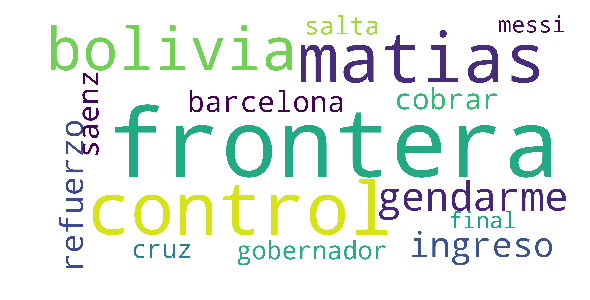

In [41]:

wordcloud = WordCloud(background_color ='white',
                      scale=10,
                relative_scaling=1).generate_from_frequencies(final['topico_rank'][0]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

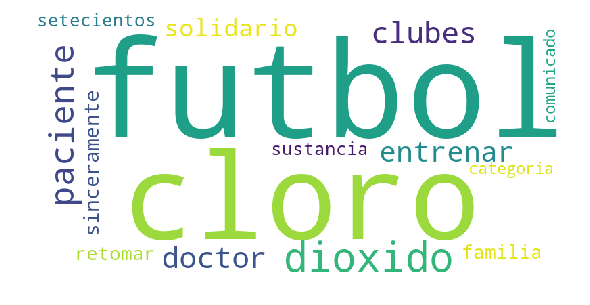

In [42]:
wordcloud = WordCloud(background_color ='white',
                      scale=2,
                relative_scaling=1).generate_from_frequencies(final['topico_rank'][5]) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 